ORGAN SEGMENTATION IPYNB

Welcome to the organ segmentation jupyter notebook! Here, we'll do the step by step functions in order to preprocess,run organ segmentation, and post-process your own LSFM whole body mouse scans!

Let's start with some imports

In [2]:
import utils
import os
import matplotlib.pyplot as plt
import numpy as np

Then, we need to set the location of the Autofluorescence and PI channels, as well as the downsampling factors. The downsampling factors should take account of what the scan resolution is. We want to obtain a target resolution of approx 60x60x60 um/voxel, so please select accordingly. In our case, that needs a downsampling factor of 10 in both xy and z directions.

In [3]:
path_base = './assets/CD68/'
mousenames = ['CD68_chow_7790']
channelnames = ['C01','C02']
downsampling_factor_xy = 10
downsampling_factor_z = 10
path_ouput_preprocessing='./assets/CD68/pipeline_test/'
folder_out_pred_nnUNET = './assets/CD68/pipeline_test/predictions/'
folder_masks_out = './assets/CD68/pipeline_test/US/'
folder_output_masked_nonorgans = './CD68/pipeline_test/Masked_nonorgans/'


if not os.path.exists(path_ouput_preprocessing):
    os.makedirs(path_ouput_preprocessing)

In [3]:
utils.downsample_folder(path_base , mousenames, channelnames , downsampling_factor_xy, downsampling_factor_z)

Downsampling data for mouse: CD68_chow_7790 by factors:  10 10
CD68_chow_7790 (C01) ----------
All files were already downsampled.
CD68_chow_7790 (C02) ----------
All files were already downsampled.
Done.


In [11]:
example_image_C00 = utils.readNifti('./assets/CD68/pipeline_test/CD68_chow_7790_fused_whole_arivis_exportC01xy10z10_0000.nii.gz')
example_image_C01 = utils.readNifti('./assets/CD68/pipeline_test/CD68_chow_7790_fused_whole_arivis_exportC01xy10z10_0001.nii.gz')
fig,axes=plt.subplots(1,2,figsize=(5,10))
axes[0].imshow(np.max(example_image_C00,axis=2),cmap='Reds')
axes[1].imshow(np.max(example_image_C01,axis=2),cmap='Blues',vmin=0,vmax=230)

for i in range(2):
    axes[i].axis('off')

./assets/CD68/pipeline_test/CD68_chow_7790_fused_whole_arivis_exportC01xy10z10_0000.nii.gz


Exception: No file found at: ./assets/CD68/pipeline_test/CD68_chow_7790_fused_whole_arivis_exportC01xy10z10_0000.nii.gz

In [4]:
utils.preprocess_zslices_to_nifti(path_base , mousenames, channelnames , downsampling_factor_xy, downsampling_factor_z, path_ouput_preprocessing)


 saved Nifti for /media/izabela/iTERM 47/CD68/pipeline_test/CD68_chow_7790_xy10_z10_0000.nii.gz
 saved Nifti for /media/izabela/iTERM 47/CD68/pipeline_test/CD68_chow_7790_xy10_z10_0001.nii.gz


Now that our data is preprocessed, we need to run the prediction of the organ segmentation network. For this, you need to have nnUNetV2 (https://github.com/MIC-DKFZ/nnUNet/tree/master) set up and ready to use.

The model is available in the /model folder, and for using it, please use the information here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/how_to_use_nnunet.md#how-to-deploy-and-run-inference-with-your-pretrained-models

Then, in your terminal, run the following line:

nnUNetv2_predict -d 68802 -i path_ouput_preprocessing -o folder_out_pred -c 3d_fullres -tr nnUNetTrainer 

Next, we want to postprocess the predictions.

In [5]:
utils.postprocess_predictions(folder_out_pred_nnUNET)

/media/izabela/iTERM 47/CD68/pipeline_test/predictions//CD68_chow_7790_xy10_z10.nii.gz


The prediction could look like this:

./assets/CD68/segmentation/segmentation_20o.nii.gz


(-0.5, 508.5, 1465.5, -0.5)

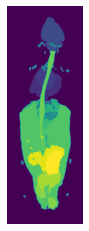

In [10]:
example_seg= utils.readNifti('./assets/CD68/segmentation/segmentation_20o.nii.gz')
plt.imshow(np.max(example_seg,axis=2),cmap = 'viridis')
plt.axis('off')

Lastly, we upsample the predictions

In [6]:
utils.upsample_prediction_mask(folder_out_pred_nnUNET,folder_out = folder_masks_out,folder_fullres_in=path_base, downsampling_factor_z=10)

Upsampling masks for mouse:  CD68_chow_7790_xy10_z10.nii.gz
/media/izabela/iTERM 47/CD68/pipeline_test/predictions//CD68_chow_7790_xy10_z10.nii.gz
Creating zslices
Upsampling the zslices
Filling in missing zslices


Optionally, we can create Masked non-organs (as preparation for the tissue prediction step)

In [5]:
utils.mask_out_organs_from_scan(folder_masks = folder_masks_out, folder_base_mice=path_base, folder_masked_out=folder_output_masked_nonorgans, channels = ['C01','C02'])

Masking out organs for mouse:  CD68_chow_7790
